In [9]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm

In [10]:
# Set the file path:
path = Path("results/")
reconstruction_algo = "ST"
solver = "GridSearch"

In [11]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [12]:
def get_config(file_path: str):
    stem = Path(file_path).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [13]:
def collect_best_records(
    path,                # e.g. "results/"
    solver,              # substring to match in filename
    reconstruction_algo  # another substring to match
):
    path = Path(path)
    group = {}

    # 1) gather all matching files into `group[name] = df`
    for file_path in path.iterdir():
        if not file_path.is_file():
            continue
        name = file_path.name
        if solver in name and reconstruction_algo in name:
            # parse_results should return a DataFrame
            group[name] = parse_results(file_path)

    # 2) error if nothing matched
    if not group:
        raise Exception(
            f"No files found in {path!r} containing "
            f"{solver!r} AND {reconstruction_algo!r}"
        )

    # 3) build a config dict for each name
    config = { name: get_config(name) for name in group }

    # 4) for each df, pick the row(s) with max score and merge in config
    best_slices = []
    for name, df in group.items():
        # select best‐score rows
        best_df = df[df['score'] == df['score'].min()].copy()

        # grab the config dict for this experiment
        conf = config[name]
        # turn it into a DataFrame with same index, then concat
        conf_df = pd.DataFrame([conf] * len(best_df), index=best_df.index)

        merged = pd.concat([best_df.reset_index(drop=True),
                            conf_df.reset_index(drop=True)],
                           axis=1)
        best_slices.append(merged)

    # 5) stitch all best‐records together
    result = pd.concat(best_slices, ignore_index=True)
    return result


In [14]:
df_best = collect_best_records("results/", solver="GridSearch", reconstruction_algo="ST")

In [15]:
def plot_score_scatter_by_params(
    df,
    x_param,
    y_param,
    figsize=(8, 5),
    cmap='viridis',
    marker='o',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    cbar_label='Score',
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT"
):
    """
    Scatter plot of score as color vs two hyperparameters.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'score' and hyperparameter columns.
    x_param : str
        Column name for x-axis.
    y_param : str
        Column name for y-axis.
    figsize : tuple, default=(8, 5)
        Figure size in inches.
    cmap : str or Colormap, default='viridis'
        Colormap for score values.
    marker : str, default='o'
        Marker style.
    alpha : float, default=0.8
        Alpha blending for markers.
    title_fontsize, label_fontsize, tick_fontsize, dpi : int
        Matplotlib styling parameters.
    cbar_label : str, default='Score'
        Label for the colorbar.
    """
    # Configure rcParams for publication-quality styling
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    sc = ax.scatter(
        df[x_param],
        df[y_param],
        # c=df['score'],
        # cmap=cmap,
        # marker=marker,
        # alpha=alpha
    )
    ax.set_title(title, pad=10)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)

    # Add colorbar
    # cbar = plt.colorbar(sc, ax=ax)
    # cbar.set_label(cbar_label)

    # Rotate tick labels if needed
    if df[x_param].nunique() > 10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    if df[y_param].nunique() > 10:
        plt.setp(ax.get_yticklabels(), rotation=45, va='top')

    plt.tight_layout()
    plt.show()



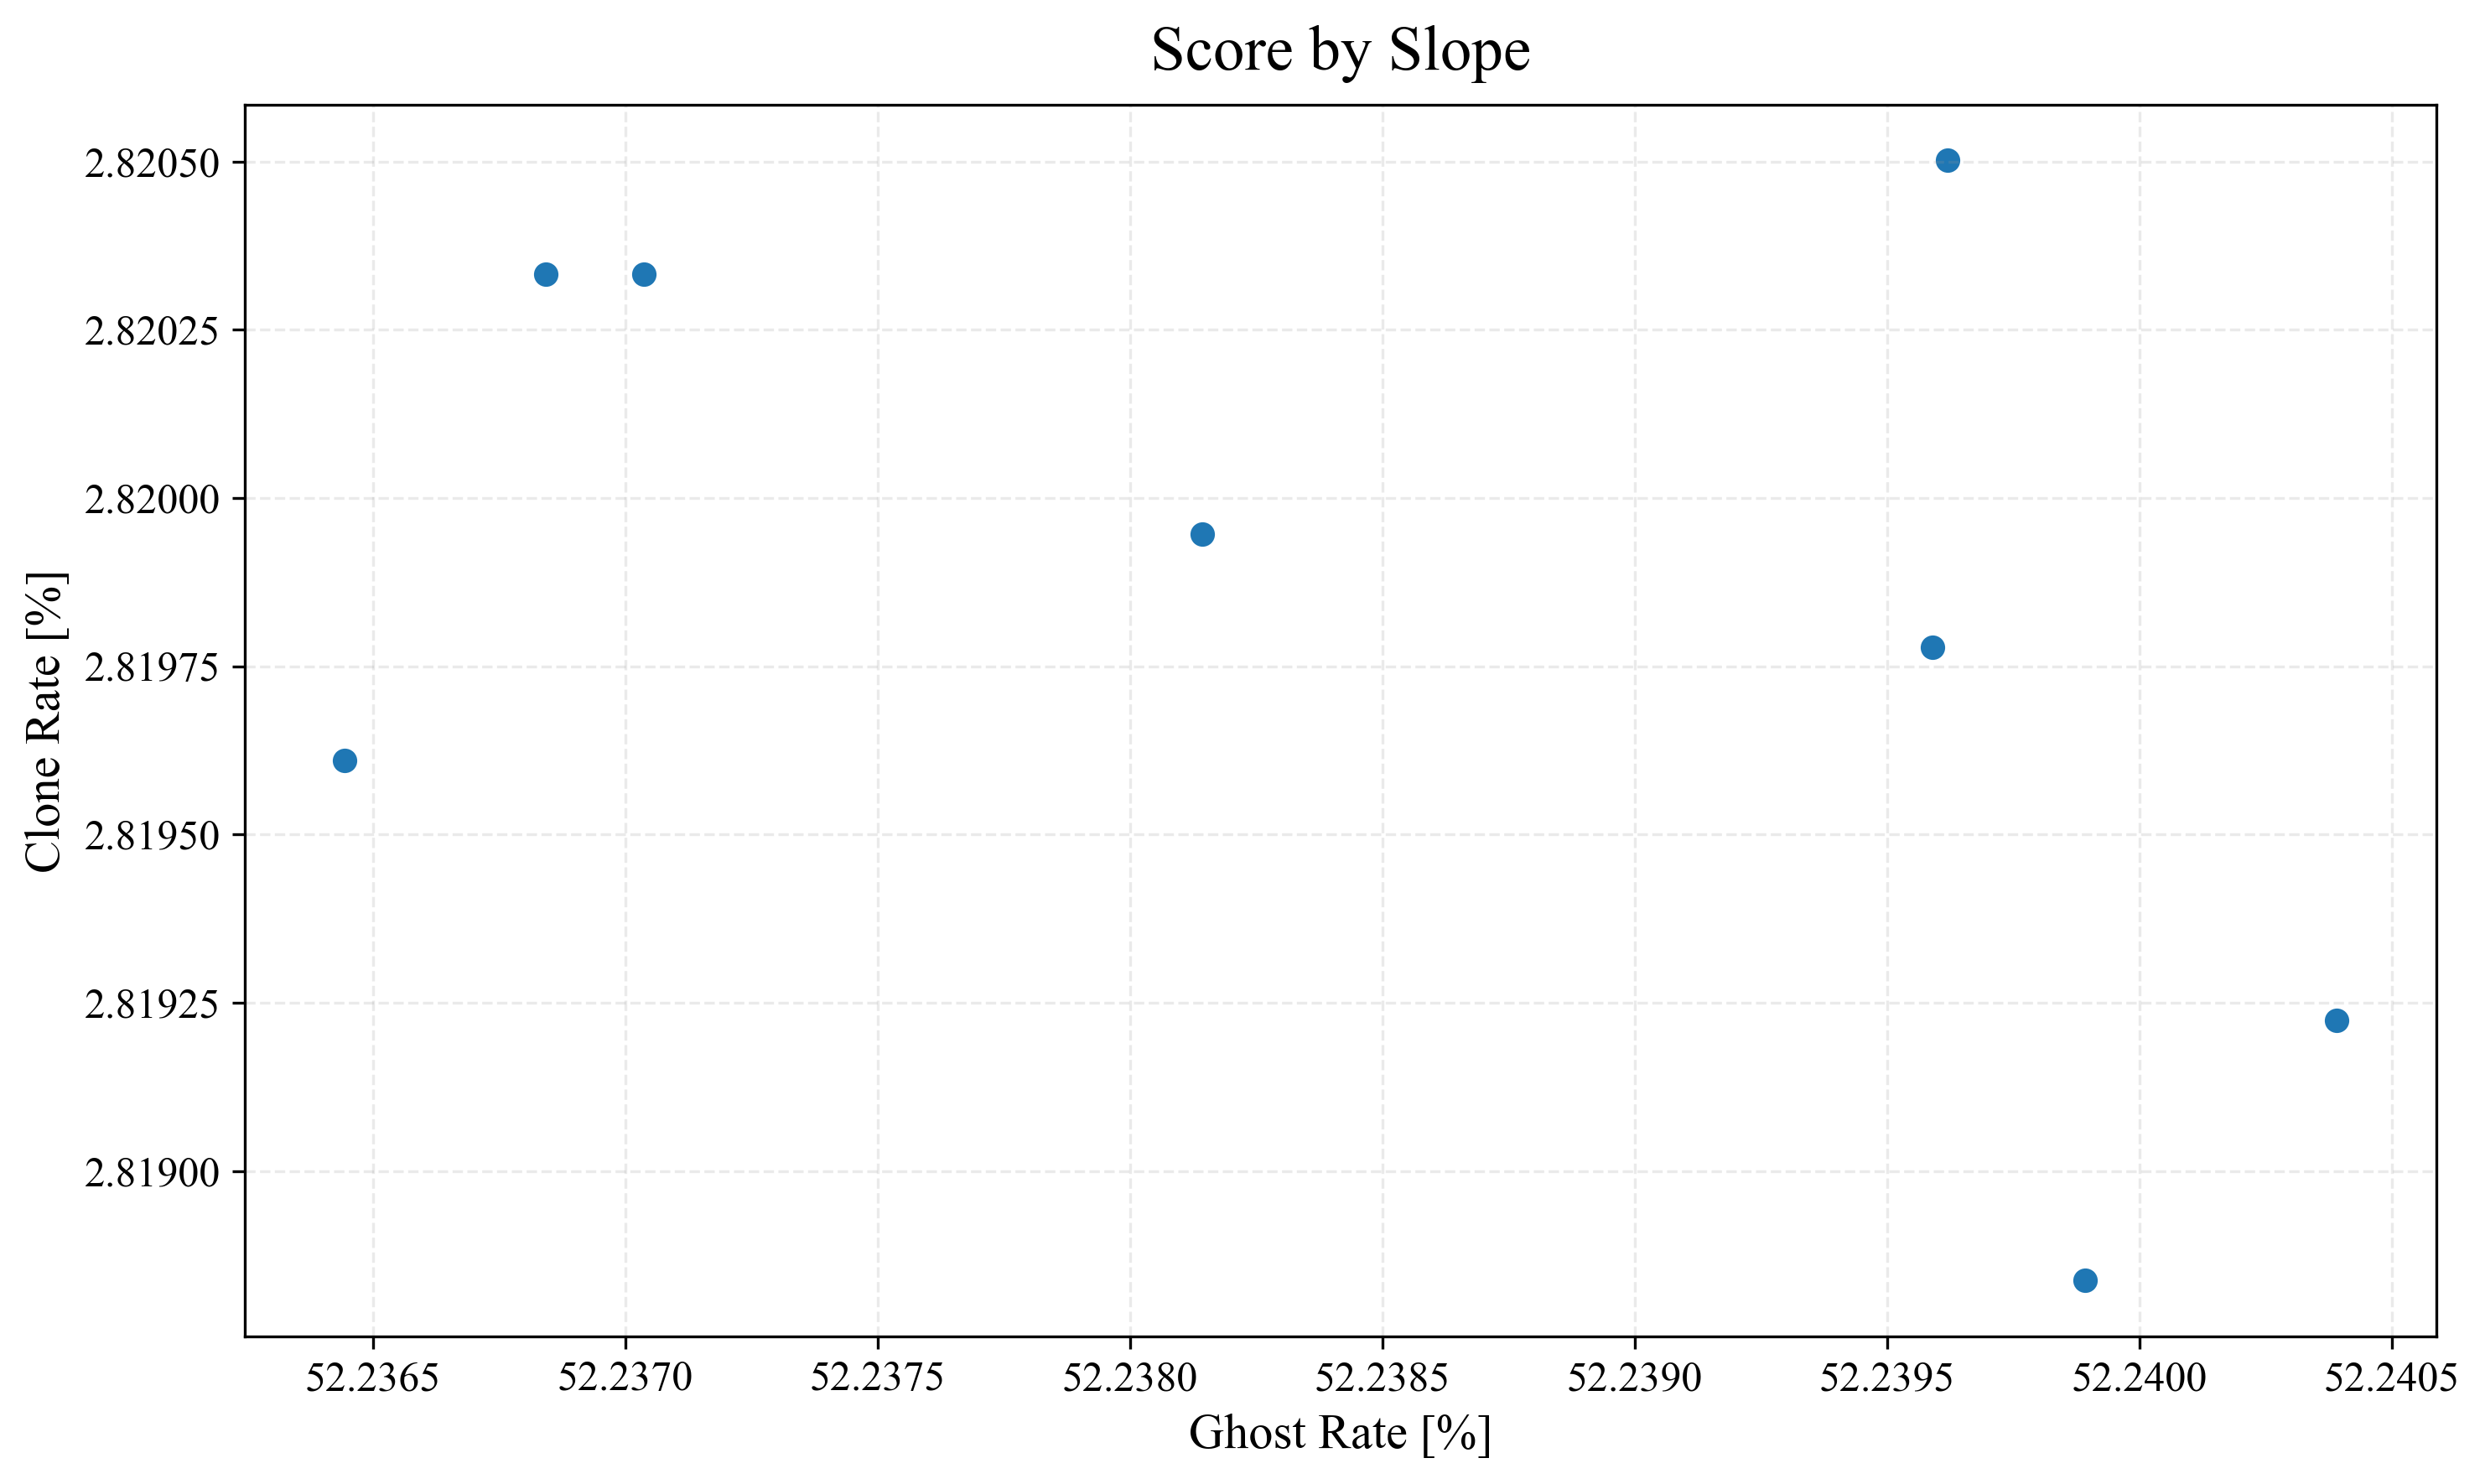

In [16]:
plot_score_scatter_by_params(
    df_best,
    x_param='event_avg_ghost_rate',
    y_param='clone_percentage',
    figsize=(10, 6),
    cmap='plasma',
    marker='s',
    alpha=0.7,
    cbar_label='Mean Score',
    title="Score by Slope",
    XTitle="Ghost Rate [%]",
    YTitle="Clone Rate [%]"
)